#**References:**
*   https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
*   https://github.com/nwojke/deep_sort
*   https://github.com/kaylode/vehicle-counting




# Checking GPU

In [ ]:
!nvidia-smi

Tue Jan  5 01:56:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Choosing Dir

In [ ]:
import os
os.chdir('/content/drive/MyDrive/v2_vehicle_counting_EfficientDet')
!ls

augmentations	 detect.py     models		 trainer
cam_10_1000.rar  eval_coco.py  README.md	 train.py
configs		 eval.py       requirements.txt  utils
counter.py	 loggers       results		 v2_demo-EfficientDet.ipynb
datasets	 losses        track.py		 weights


# Installing Package

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -U PyYAML

In [ ]:
!pip install labelme2coco

# Split into Frames
Chia Video thành từng Frames.

In [ ]:
!python split.py --path='/content/drive/MyDrive/v1_vehicle_counting_EfficientDet/datasets/videos/' --out='/content/drive/MyDrive/v1_vehicle_counting_EfficientDet/datasets/aic-hcmc2020/split'

# Sau khi ta dán nhãn thủ công bằng labelme ta được file JSON, sau đó ta chuyển đổi format labelme sang COCO.

In [ ]:
# import package
import labelme2coco

# set directory that contains labelme annotations and image files
#labelme_folder = "/content/drive/MyDrive/v1_vehicle_counting_EfficientDet/datasets/aic-hcmc2020/images"

# set path for coco json to be saved
#save_json_path = "/content/drive/MyDrive/v1_vehicle_counting_EfficientDet/datasets/aic-hcmc2020/annotations/instances_train.json"

# convert labelme annotations to coco
#labelme2coco.convert(labelme_folder, save_json_path)

# Visualize Data
Tập dữ liệu gồm 100 ảnh (cam_0404) được dãn nhãn thủ công và được chia thành 80 ảnh cho TrainingSet và 20 ảnh cho ValidateSet.

In [ ]:
!unrar x '/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/cam_10_1000.rar' '/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets'

In [ ]:
!find '/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets/images' -maxdepth 1 -type f | wc -l

1040


In [ ]:
!pip install tensorboardX

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np
from PIL import Image
from augmentations.transforms import Compose

class ObjectDetectionDataset(data.Dataset):
    """
    - Object Detection dataset for COCO Format Only
    - Bounding boxes in format x1,y1,w,h
    - Init argument:
                + img_dir: Directory to images
                + ann_path: Path to annotation file (.json)

    """
    def __init__(self,
                 img_dir,
                 ann_path,
                 transforms = None,
                 max_samples = None,
                 shuffle = False):
      
        self.dir = img_dir
        self.ann_path = ann_path
        _, self.ext = os.path.splitext(ann_path)
        self.shuffle = shuffle
        self.transforms = transforms if transforms is not None else Compose()     
        self.max_samples = max_samples
        self.annos = self.load_annos()
        self.labels_to_idx()
        self.fns = self.load_images()

    def labels_to_idx(self):
        """
        Create dictionary for label to indexes
        """
        self.classes_idx = {}
        self.idx_classes = {}
        self.classes = []
        for i in self.annos["categories"]:
            self.classes.append(i['name'])
            self.classes_idx[i['name']] = i['id']
            self.idx_classes[i['id']] = i['name']

    def load_annos(self):
        """
        Read in data from annotations
        """
        with open(self.ann_path, "r") as fi:
            if self.ext == ".json":
                import json
                data = json.load(fi)

        for i in data['annotations']:
            i['category_id'] -= 1               # Label index starts with 0
        for i in data['categories']:
            i['id'] -= 1
        return data

    

    def load_images(self):
        """
        Read in list of paths to images
        """
        data_list = [os.path.join(self.dir,i['file_name']) for i in self.annos['images']]
        if self.shuffle:
            random.shuffle(data_list)
        data_list = data_list[:self.max_samples] if self.max_samples is not None else data_list
        return data_list
    
    def count_dict(self, types = 1):
        """
        Count class frequencies
        """
        cnt_dict = {}
        if types == 1: # Object Frequencies
            for cl in self.classes:
                num_objs = sum([1 for i in self.annos['annotations'] if i['category_id'] == self.classes_idx[cl]])
                cnt_dict[cl] = num_objs
        elif types == 2:
            pass
        return cnt_dict

    def plot(self, figsize = (8,8), types = ["freqs"]):
        """
        Plot classes distribution
        """
        ax = plt.figure(figsize = figsize)
        
        if "freqs" in types:
            cnt_dict = self.count_dict(types = 1)
            plt.title("Total objects can be seen: "+ str(sum(list(cnt_dict.values()))))
            bar1 = plt.bar(list(cnt_dict.keys()), list(cnt_dict.values()), color=[np.random.rand(3,) for i in range(len(self.classes))])
            for rect in bar1:
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
        
        plt.show()

    def visualize_item(self, index = None, figsize=(15,15), box_transforms = True):
        """
        Visualize an image with its bouding boxes by index
        """

        if index is None:
            index = random.randint(0,len(self.fns))
        item = self.__getitem__(index)
        img = item['img']
        box = item['box']
        label = item['label']

        # Denormalize and reverse-tensorize
        if box_transforms:
            results = self.transforms.denormalize(img = img, box = box, label = label)
            img, label, box = results['img'], results['label'], results['box']
        else:
            results = self.transforms.denormalize(img = img, box = None, label = label)
            img, label, _ = results['img'], results['label'], results['box']

        # Numpify
        label = label.numpy()
        box = box.numpy()

        self.visualize(img, box, label, figsize = figsize)

    
    def visualize(self, img, boxes, labels, figsize=(15,15)):
        """
        Visualize an image with its bouding boxes
        """
        fig,ax = plt.subplots(figsize=figsize)

        # Display the image
        ax.imshow(img)

        # Create a Rectangle patch
        for box, label in zip(boxes, labels):
            color = np.random.rand(3,)
            x,y,w,h = box
            rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor = color,facecolor='none')
            plt.text(x, y-3, self.idx_classes[label], color = color, fontsize=20)
            # Add the patch to the Axes
            ax.add_patch(rect)
        plt.show()

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, index):
        """
        Get an item by index
        """
        img_item = self.annos['images'][index]
        img_id = img_item['id']
        img_name = img_item['file_name']
        img_anno = [i for i in list(self.annos['annotations']) if i['image_id'] == img_id]
        
        img_path = os.path.join(self.dir,img_name)
        box = np.floor(np.array([i['bbox'] for i in img_anno]))
        
        label = np.array([i['category_id'] for i in img_anno]) # Label starts from 0

        img = Image.open(img_path)

        # Data augmentation
        results = self.transforms(img = img, box = box, label = label)
        

        return {
            'img': results['img'],
            'box': results['box'],
            'label': results['label'],
        }

    def collate_fn(self, batch):
        """
        - Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        - This describes how to combine these tensors of different sizes. We use lists.
        - Note: this need not be defined in this Class, can be standalone.
            + param batch: an iterable of N sets from __getitem__()
            + return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
    
        for b in batch:
            images.append(b['img'])
            boxes.append(b['box'])
            labels.append(b['label'])
            
        images = torch.stack(images, dim=0)

        return {
            'imgs': images,
            'boxes': boxes,
            'labels': labels} # tensor (N, 3, 300, 300), 3 lists of N tensors each

    def __str__(self):
        s = "Custom Dataset for Object Detection\n"
        line = "-------------------------------\n"
        s1 = "Number of samples: " + str(len(self.fns)) + '\n'
        s2 = "Number of classes: " + str(len(self.classes)) + '\n'
        return s + line + s1 + s2
        

In [ ]:
#from datasets.detection import ObjectDetectionDataset
from augmentations.transforms import *
transforms = Compose([
      ToTensor(),
      Normalize(),
])
trainset = ObjectDetectionDataset(img_dir='/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets/images', 
                                  ann_path='/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets/annotations/instances_train.json',transforms=transforms)
valset = ObjectDetectionDataset(img_dir='/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets/images', 
                                ann_path='/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/datasets/custom_datasets/annotations/instances_val.json',transforms=transforms)

In [ ]:
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 80
Number of classes: 4

Custom Dataset for Object Detection
-------------------------------
Number of samples: 20
Number of classes: 4



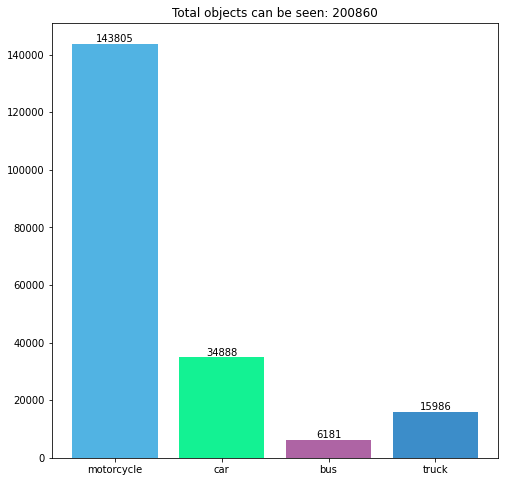

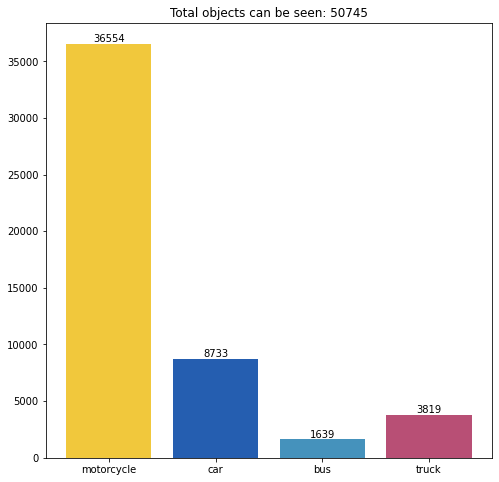

In [ ]:
trainset.plot()
valset.plot()

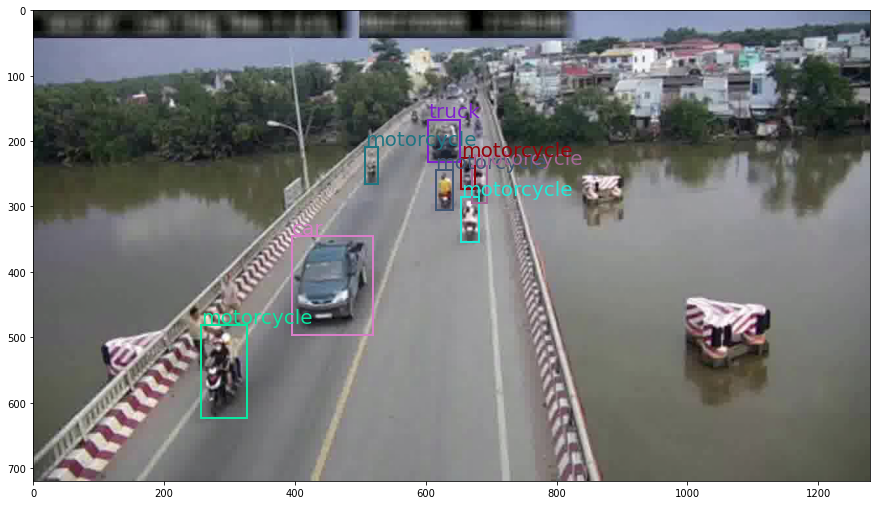

In [ ]:
trainset.visualize_item(figsize=(15,15))

# Fine-Tuning Pre-trained Model For cam_04 (efficientdet-d2.pth aka EfficientDet_27_146712_interrupted.pth).
Ở bước này ta thực hiện fine-tuning model đã được train trước đó dựa trên 100 ảnh đã được dãn nhãn thủ công dành riêng cho cam_04.
input: efficientdet-d2.pth --> output: EfficientDet_20_419.pth(fine-tuned).

In [ ]:
!python train.py

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Loaded Successfully!
2020-12-29 17:34:17.667003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
---------MODEL INFO----------------
Model name: EfficientDet
Number of trainable parameters:  8,009,577
Loss function: FocalLoss
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
Training iterations per epoch: 20
Validating iterations per epoch: 5
===========================START TRAINING=================================
[0|20] [10|420] || C: 0.09795 || B: 0.59655 || T: 0.6945 || Time:     6.7528s
[0|20] [20|420] || C: 0.12313 || B: 0.48356 || T: 0.60669 || Time:     6.3812s
=============================EVALUATION===================================
100% 5/5 [

# Evaluate Model Performance
Đánh giá model theo hai metric Precision và Recall
(weights: EfficientDet_20_419.pth).

In [ ]:
!python eval_coco.py

Loaded Successfully!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
100% 20/20 [00:02<00:00,  9.23it/s]
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.490
 Average

# Vehicle Detection
output: results/detection 
(danh sách các bounding box, confidence score, classclass_id theo từng frameframe).

In [ ]:
!python detect.py

Loaded Successfully!
  7% 400/6000 [00:52<12:14,  7.63it/s]


# Vehicle Tracking & Counting Results

In [ ]:
!python track.py cam_04

  0% 0/6000 [00:00<?, ?it/s]1
2
3
/content/drive/MyDrive/v2_vehicle_counting_EfficientDet/utils/utils.py:391: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
  7% 400/6000 [00:24<05:39, 16.48it/s]
----
name:  cam_04
path:  results
